## 0. Computer vision libraries in PyTorch

* `torch.vison` - Base domain library for computer vision.
* `torchvision.datasets` - get datasets and data loading functions for computer vision problems.
* `torchvision.models` - get pretrained computer vision problems that you can leverage for your problems.
* `torchvision.transforms` - functions for manpulating your vision data (images) to be suitable for use with an ML model.
* `torch.utils.data.Dataset` - Base dataset class for PyTorch.
* `torch.utils.data.DataLoader` - Creates a Python iterable over a dataset.

In [1]:
# Import PyTorch
import torch
from torch import nn

# Import torchvision
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

# Import matplotlib for visualization
import matplotlib.pyplot as plt

# Check versions
print(torch.__version__)
print(torchvision.__version__)

2.1.0+cu118
0.16.0+cu118


## 1. Getting a dataset

The dataset we'll be using is Fashion MNIST from torchvision.datasets.

In [2]:
# Setup training data
train_data = datasets.FashionMNIST(
    root = "data", # where to download data to
    train = True, # do we want the training dataset?
    download = True, # do we want to download it?
    transform = torchvision.transforms.ToTensor(), # how do we want to transform the data?
    target_transform = None, # how do we want to transform the labels/target?
)

test_data = datasets.FashionMNIST(
    root = "data",
    train = False,
    download = True,
    transform = ToTensor(), # Same as torchvision.transforms.ToTensor()
    target_transform = None
)

In [3]:
len(train_data), len(test_data)

(60000, 10000)

In [4]:
# See the first training example
image, label = train_data[0]
image, label

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0039, 0.0000, 0.0000, 0.0510,
           0.2863, 0.0000, 0.0000, 0.0039, 

In [5]:
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [6]:
class_to_idx = train_data.class_to_idx
class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

In [7]:
train_data.targets

tensor([9, 0, 0,  ..., 3, 0, 5])

### 1.1 Check the input and outputs shapes of data

In [8]:
# Check the shape of our image
print(f"Image shape: {image.shape} -> [color channels, height, width]")
print(f"Image Label: {label}")

Image shape: torch.Size([1, 28, 28]) -> [color channels, height, width]
Image Label: 9


### 1.2 Visualizing our data

Image shape: torch.Size([1, 28, 28])


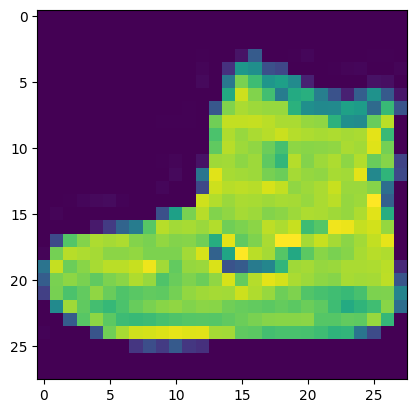

In [9]:
import matplotlib.pyplot as plt
image, label = train_data[0]
print(f"Image shape: {image.shape}")
plt.imshow(image.squeeze()) # matplotlib expects only height and width, if we wanna pass the color channels we will pass at last

(-0.5, 27.5, 27.5, -0.5)

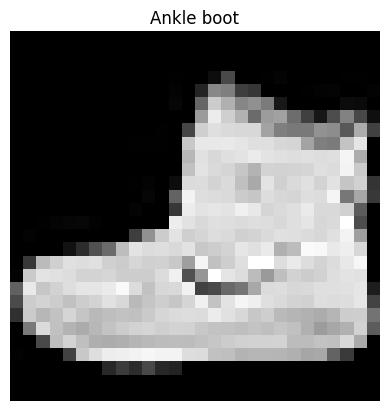

In [10]:
plt.imshow(image.squeeze(), cmap = 'gray')
plt.title(class_names[label])
plt.axis(False)

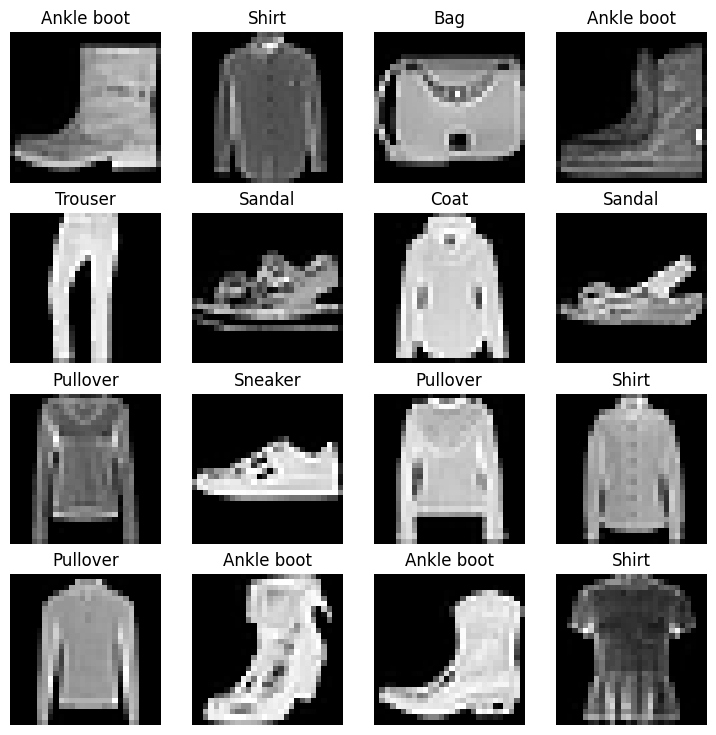

In [11]:
# Plot more images
torch.manual_seed(42)
fig = plt.figure(figsize = (9,9))
rows, cols = 4, 4
for i in range(1, rows*cols+1):
  random_idx = torch.randint(0, len(train_data), size = [1]).item()
  img, label = train_data[random_idx]
  fig.add_subplot(rows, cols, i)
  plt.imshow(img.squeeze(), cmap = 'gray')
  plt.title(class_names[label])
  plt.axis(False)

Do you think these items of clothing (images) could be modeled with pure linear lines? Or do you think we'll need non-linearities?

In [12]:
train_data, test_data

(Dataset FashionMNIST
     Number of datapoints: 60000
     Root location: data
     Split: Train
     StandardTransform
 Transform: ToTensor(),
 Dataset FashionMNIST
     Number of datapoints: 10000
     Root location: data
     Split: Test
     StandardTransform
 Transform: ToTensor())

## 2. Prepare DataLoader

Right now, our data is in the form of PyTorch Datasets.

DataLoader turns our dataset into a Python iterable.

More specifically, we want to turn our data into batches (or mini-batches).

Why would we do this?

1. It is more computationally efficient, as in, your computing hardware may not be able to look (store in memory) at 60000 images in one hit. So we break it down to 32 images at a time (batch size of 32).
2. It gives our nueral network more chances to update its gradients per epoch.

In [13]:
from torch.utils.data import DataLoader

# Setup the batch size hyperparameter
BATCH_SIZE = 32

# Turn datasets into iterables (batches)
train_dataloader = DataLoader(dataset = train_data,
                              batch_size = BATCH_SIZE,
                              shuffle = True)

test_dataloader = DataLoader(dataset = test_data,
                             batch_size = BATCH_SIZE,
                             shuffle = False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7b4e4da9afb0>,
 <torch.utils.data.dataloader.DataLoader at 0x7b4e4e005d50>)

In [14]:
# Let's check out what we've created
print(f"DataLoaders: {train_dataloader, test_dataloader}")
print(f"Length of train_dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}...")
print(f"Length of test_dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}...")

DataLoaders: (<torch.utils.data.dataloader.DataLoader object at 0x7b4e4da9afb0>, <torch.utils.data.dataloader.DataLoader object at 0x7b4e4e005d50>)
Length of train_dataloader: 1875 batches of 32...
Length of test_dataloader: 313 batches of 32...


In [15]:
# Check out what's inside the training dataloader
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

Image size: torch.Size([1, 28, 28])
Label: 6, label size: torch.Size([])


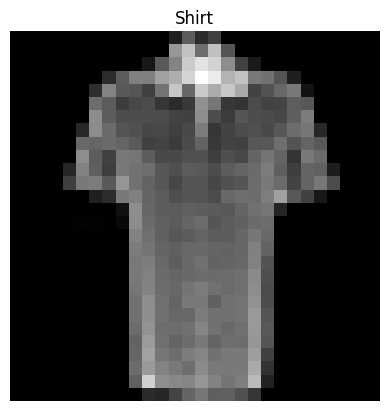

In [16]:
# Show a sample
torch.manual_seed(42)
random_idx = torch.randint(0, len(train_features_batch), size =[1]).item()
img, label = train_features_batch[random_idx], train_labels_batch[random_idx]
plt.imshow(img.squeeze(), cmap = "gray")
plt.title(class_names[label])
plt.axis(False)
print(f"Image size: {img.shape}")
print(f"Label: {label}, label size: {label.shape}")

## 3. Model 0: Build a baseline model

When starting to build a series of machine learning modeling experiments it's best practice to start with a baseline model.

A baseline model is a simple model you will try and improve upon with subsequent models/experiments.

In other words, start simply and add complexity when necessary.

In [17]:
# Create a flatten layer
flatten_model = nn.Flatten()

# Get a single sample
x = train_features_batch[0]

# Flatten the sample
output = flatten_model(x) # perform forward pass

# Print out what happened
print(f"Shape before flattening: {x.shape} -> [color_channels, height, width]")
print(f"Shape after flattening: {output.shape} -> [color_channels, height * width]")

Shape before flattening: torch.Size([1, 28, 28]) -> [color_channels, height, width]
Shape after flattening: torch.Size([1, 784]) -> [color_channels, height * width]


In [18]:
from torch import nn
class FashionMNISTModelV0(nn.Module):
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
    super().__init__()
    self.layerstack = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features = input_shape,
                  out_features = hidden_units),
        nn.Linear(in_features = hidden_units,
                  out_features = output_shape)
    )

  def forward(self, x):
    return self.layerstack(x)

In [19]:
torch.manual_seed(42)

# Setup model with input parameters
model_0 = FashionMNISTModelV0(
    input_shape = 784, # this is 28 * 28
    hidden_units = 10, # how many units in the hidden layer
    output_shape = len(class_names) # one for every class
).to("cpu")

model_0

FashionMNISTModelV0(
  (layerstack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [20]:
dummy_x = torch.rand([1, 1, 28, 28])
model_0(dummy_x)

tensor([[-0.0315,  0.3171,  0.0531, -0.2525,  0.5959,  0.2112,  0.3233,  0.2694,
         -0.1004,  0.0157]], grad_fn=<AddmmBackward0>)

 ### 3.1 Setup loss, optimizer and evaluation metrics

 * Loss function - since we're working with multi-class data, our loss function will be `nn.CrossEntropyLoss()`
 * Optimizer - our optimizer `torch.optim.SGD()` (stochastic gradient descent)
 * Evaluation metric - since we're working with a classification problem, let's use `accuracy` as our evluation metric

In [21]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo
if Path('helper_functions.py').is_file():
  print('helper_functions.py already exists, skipping download...')
else:
  print("Downloading helper_functions.py")
  request = requests.get('https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py')
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

helper_functions.py already exists, skipping download...


In [22]:
# Import accuracy metric
from helper_functions import accuracy_fn

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params = model_0.parameters(),
                            lr = 0.1)

### 3.2 Creating a function to time our experiments

Machine Learning is very experimental.

Two of the main things you'll often want to track are:
1. Model's performance (loss and accuracy values etc)
2. How fast it runs

In [23]:
from timeit import default_timer as timer
def print_train_time(start: float,
                     end: float,
                     device: torch.device = None):
  """Prints difference between start and end time."""
  total_time = end - start
  print(f"Train time on {device}: {total_time: .3f} seconds")
  return total_time

In [24]:
start_time = timer()
# some code...
end_time = timer()
print_train_time(start = start_time, end = end_time, device = "cpu")

Train time on cpu:  0.000 seconds


2.7285999749437906e-05

### 3.3 Creating a training loop and training a model on batches of data

1. Loop through epochs.
2. Loop through training batches, perform training steps, calculate the train loss *per batch*.
3. Loop through testing batches, perform testing steps, calculate the test loss *per batch*.
4. Print out what's happening.
5. Time it all (for fun).

In [25]:
# Import tqdm for progress bar
from tqdm.auto import tqdm

# Set the seed and start the timer
torch.manual_seed(42)
train_time_start_on_cpu = timer()

# Set the number of epochs (we'll keep this small for faster training time)
epochs = 3

# Create a training loop
for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n------")
  ### Training
  train_loss = 0
  # Add a loop to loop through the training batches
  for batch, (X, y) in enumerate(train_dataloader):
    model_0.train()
    # 1. Forward pass
    y_pred = model_0(X)

    # 2. Calculate the loss (per batch)
    loss = loss_fn(y_pred, y)
    train_loss += loss # accumulate train loss

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    # Print out what's happening
    if batch % 400 == 0:
      print(f"Looked at: {batch * len(X)} / {len(train_dataloader.dataset)} samples")

  # Divide total train loss by length of train dataloader
  train_loss /= len(train_dataloader)

  ### Testing
  test_loss, test_acc = 0, 0
  model_0.eval()
  with torch.inference_mode():
    for X_test, y_test in test_dataloader:
      # 1. Forward pass
      test_pred = model_0(X_test)

      # 2. Caluclate pass (accumalatively)
      test_loss += loss_fn(test_pred, y_test)

      # 3. Calculate the accuracy
      test_acc += accuracy_fn(y_true = y_test, y_pred = test_pred.argmax(dim = 1))

    # Calculate the test loss average per batch
    test_loss /= len(test_dataloader)

    # Calculate the test acc average per batch
    test_acc /= len(test_dataloader)

    # Print out what's happening
    print(f"\nTrain loss: {train_loss: .4f} | Test loss {test_loss: .4f} | Test Acc {test_acc: .4f}%")

# Calculate training time
train_time_end_on_cpu = timer()
total_train_time_model_0 = print_train_time(start = train_time_start_on_cpu,
                                            end = train_time_end_on_cpu,
                                            device = str(next(model_0.parameters()).device))

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
------
Looked at: 0 / 60000 samples
Looked at: 12800 / 60000 samples
Looked at: 25600 / 60000 samples
Looked at: 38400 / 60000 samples
Looked at: 51200 / 60000 samples

Train loss:  0.5904 | Test loss  0.5095 | Test Acc  82.0387%
Epoch: 1
------
Looked at: 0 / 60000 samples
Looked at: 12800 / 60000 samples
Looked at: 25600 / 60000 samples
Looked at: 38400 / 60000 samples
Looked at: 51200 / 60000 samples

Train loss:  0.4763 | Test loss  0.4799 | Test Acc  83.1969%
Epoch: 2
------
Looked at: 0 / 60000 samples
Looked at: 12800 / 60000 samples
Looked at: 25600 / 60000 samples
Looked at: 38400 / 60000 samples
Looked at: 51200 / 60000 samples

Train loss:  0.4550 | Test loss  0.4766 | Test Acc  83.4265%
Train time on cpu:  40.004 seconds


## 4. Make predictions and get Model 0 results

In [26]:
torch.manual_seed(42)
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn):
  """Returns a dictionary containing the results of model predicting on data_loader."""
  loss, acc = 0, 0
  model.eval()
  with torch.inference_mode():
    for X, y in tqdm(data_loader):
      # Make predictions
      y_pred = model(X)

      # Accumulate the loss and accuracy values per batch
      loss += loss_fn(y_pred, y)
      acc += accuracy_fn(y_true = y, y_pred = y_pred.argmax(dim = 1))

    # Scale the loss and acc to find the average loss/acc per batch
    loss /= len(data_loader)
    acc /= len(data_loader)

  return {"model_name": model.__class__.__name__, # only works when model was created with a class
          "model_loss": loss.item(), # for a single value we used .item()
          "model_acc": acc
          }

In [27]:
# Calculate model 0 results on dataset
model_0_results = eval_model(model = model_0, data_loader = test_dataloader, loss_fn = loss_fn, accuracy_fn = accuracy_fn)

model_0_results

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.47663888335227966,
 'model_acc': 83.42651757188499}

## 5. Setup device agnostic-code (for using a GPU if there is one)

In [28]:
# Setup device-agnostic code
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 6. Model 1: Building a better model with non-linearity

We learned about the power of non-linearity in notebook-02.

In [29]:
# Create a model with linear and non-linear layers
class FashionMNISTModelV1(nn.Module):
  def __init__(self,
               input_shape: int,
               hidden_units: int,
               output_shape: int):
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Flatten(), # Flatten inputs into a single vector
        nn.Linear(in_features = input_shape,
                  out_features = hidden_units),
        nn.ReLU(),
        nn.Linear(in_features = hidden_units,
                  out_features = output_shape),
        nn.ReLU()
    )

  def forward(self, x: torch.Tensor):
    return self.layer_stack(x)

In [30]:
torch.manual_seed(42)
model_1 = FashionMNISTModelV1(input_shape=784, # number of input features
    hidden_units=10,
    output_shape=len(class_names) # number of output classes desired
).to(device) # send model to GPU if it's available
next(model_1.parameters()).device # check model device

device(type='cuda', index=0)

### 6.1 Setup loss, optimizer and evaluation metrics

In [31]:
from helper_functions import accuracy_fn
loss_fn = nn.CrossEntropyLoss() # measure how wrong our model is
optimizer = torch.optim.SGD(params = model_1.parameters(), #tries to update our model's parameters to reduce the loss
                            lr = 0.1)

### 6.2 Functionizing training and evaluation/testing loops

Let's create a function for:
* training loop - `train_step()`
* testing loop - `test_step()`

In [32]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
    train_loss, train_acc = 0, 0
    model.to(device)
    for batch, (X, y) in enumerate(data_loader):
        # Send data to GPU
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_true=y,
                                 y_pred=y_pred.argmax(dim=1)) # Go from logits -> pred labels

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

    # Calculate loss and accuracy per epoch and print out what's happening
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")

In [33]:
def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    test_loss, test_acc = 0, 0
    model.to(device)
    model.eval() # put model in eval mode
    # Turn on inference context manager
    with torch.inference_mode():
        for X, y in data_loader:
            # Send data to GPU
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred = model(X)

            # 2. Calculate loss and accuracy
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true=y,
                y_pred=test_pred.argmax(dim=1) # Go from logits -> pred labels
            )

        # Adjust metrics and print out
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")

In [34]:
torch.manual_seed(42)

# Measure time
from timeit import default_timer as timer
train_time_start_on_gpu = timer()

epochs = 3
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    train_step(data_loader=train_dataloader,
        model=model_1,
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn
    )
    test_step(data_loader=test_dataloader,
        model=model_1,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn
    )

train_time_end_on_gpu = timer()
total_train_time_model_1 = print_train_time(start=train_time_start_on_gpu,
                                            end=train_time_end_on_gpu,
                                            device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 1.09199 | Train accuracy: 61.34%
Test loss: 0.95636 | Test accuracy: 65.00%

Epoch: 1
---------
Train loss: 0.78101 | Train accuracy: 71.93%
Test loss: 0.72227 | Test accuracy: 73.91%

Epoch: 2
---------
Train loss: 0.67027 | Train accuracy: 75.94%
Test loss: 0.68500 | Test accuracy: 75.02%

Train time on cuda:  38.154 seconds


> **Note:** Sometimes, depending on your data/hardware you might find that your model trains faster no CPU than GPU.

>
> Why is this?
>
> 1. It could be that the overhead for copying data/model to and from the GPU outweights the compute benefits offere by the GPU.
> 2. The hardware you're using has a better CPU in terms of compute capability than the GPU.

In [35]:
torch.manual_seed(42)
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn):
  """Returns a dictionary containing the results of model predicting on data_loader."""
  loss, acc = 0, 0
  model.eval()
  with torch.inference_mode():
    for X, y in tqdm(data_loader):
      # Put the data on device
      X, y = X.to(device), y.to(device)

      # Make predictions
      y_pred = model(X)

      # Accumulate the loss and accuracy values per batch
      loss += loss_fn(y_pred, y)
      acc += accuracy_fn(y_true = y, y_pred = y_pred.argmax(dim = 1))

    # Scale the loss and acc to find the average loss/acc per batch
    loss /= len(data_loader)
    acc /= len(data_loader)

  return {"model_name": model.__class__.__name__, # only works when model was created with a class
          "model_loss": loss.item(), # for a single value we used .item()
          "model_acc": acc
          }

In [36]:
# Get model_1 results dictionary
model_1_results = eval_model(model = model_1,
                             data_loader = test_dataloader,
                             loss_fn = loss_fn,
                             accuracy_fn = accuracy_fn)
model_1_results

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'FashionMNISTModelV1',
 'model_loss': 0.6850008964538574,
 'model_acc': 75.01996805111821}

## 7. Model 2: Building a Convolutional Nueral Networks (CNN)

CNN's are also known as ConvNets.

CNN's are known for their capabilities to find patterns in visual data.

In [37]:
# Create a convolutional neural network
class FashionMNISTModelV2(nn.Module):
    """
    Model architecture copying TinyVGG from:
    https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=1),# options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from?
            # It's because each layer of our network compresses and changes the shape of our inputs data.
            nn.Linear(in_features=hidden_units*7*7,
                      out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
        x = self.block_1(x)
        # print(f"Output shape of conv_block_1: {x.shape}")
        x = self.block_2(x)
        # print(f"Output shape of conv_block_2: {x.shape}")
        x = self.classifier(x)
        # print(f"Output shape of classifier: {x.shape}")
        return x

In [38]:
torch.manual_seed(42)
model_2 = FashionMNISTModelV2(input_shape = 1, # number of color channels
                              hidden_units = 10,
                              output_shape = len(class_names)).to(device)

In [39]:
rand_image_tensor = torch.randn(size = (1, 28, 28))
rand_image_tensor.shape

torch.Size([1, 28, 28])

In [40]:
model_2(rand_image_tensor.unsqueeze(0).to(device))

tensor([[ 0.0366, -0.0940,  0.0686, -0.0485,  0.0068,  0.0290,  0.0132,  0.0084,
         -0.0030, -0.0185]], device='cuda:0', grad_fn=<AddmmBackward0>)

### 7.1 Stepping through `nn.Conv2d()` with some dummy data



In [41]:
torch.manual_seed(42)

# Create a batch of images
images = torch.randn(size = (32, 3, 64, 64))
test_image = images[0]
print(f"Image batch shape: {image.shape}")
print(f"Single image shape: {test_image.shape}")
print(f"Test image:\n {test_image}")

Image batch shape: torch.Size([1, 28, 28])
Single image shape: torch.Size([3, 64, 64])
Test image:
 tensor([[[ 1.9269,  1.4873,  0.9007,  ...,  1.8446, -1.1845,  1.3835],
         [ 1.4451,  0.8564,  2.2181,  ...,  0.3399,  0.7200,  0.4114],
         [ 1.9312,  1.0119, -1.4364,  ..., -0.5558,  0.7043,  0.7099],
         ...,
         [-0.5610, -0.4830,  0.4770,  ..., -0.2713, -0.9537, -0.6737],
         [ 0.3076, -0.1277,  0.0366,  ..., -2.0060,  0.2824, -0.8111],
         [-1.5486,  0.0485, -0.7712,  ..., -0.1403,  0.9416, -0.0118]],

        [[-0.5197,  1.8524,  1.8365,  ...,  0.8935, -1.5114, -0.8515],
         [ 2.0818,  1.0677, -1.4277,  ...,  1.6612, -2.6223, -0.4319],
         [-0.1010, -0.4388, -1.9775,  ...,  0.2106,  0.2536, -0.7318],
         ...,
         [ 0.2779,  0.7342, -0.3736,  ..., -0.4601,  0.1815,  0.1850],
         [ 0.7205, -0.2833,  0.0937,  ..., -0.1002, -2.3609,  2.2465],
         [-1.3242, -0.1973,  0.2920,  ...,  0.5409,  0.6940,  1.8563]],

        [[-0.797

In [42]:
test_image.shape

torch.Size([3, 64, 64])

In [43]:
torch.manual_seed(42)
# Create a single conv2d layer
conv_layer = nn.Conv2d(
    in_channels = 3, # color channels
    out_channels = 10, # number of hidden units
    kernel_size = (3,3), # Size of the kernel (filter)
    stride = 1, # Step size
    padding = 0, # To balance out the edges we need padding sometimes
)

# Pass the data through the convolutional layer
conv_output = conv_layer(test_image)
conv_output.shape

torch.Size([10, 62, 62])

### 7.2 Stepping through `nn.MaxPool2d()` with dummy data

In [44]:
test_image.shape

torch.Size([3, 64, 64])

In [45]:
# Print out the original image without unsqueezed dimension
print(f"Test image original shape: {test_image.shape}")
print(f"Test image with unsqueezed dimension: {test_image.unsqueeze(0).shape}")

# Create a sample nn.MaxPool2d layer
max_pool_layer = nn.MaxPool2d(kernel_size = 2) # how much compression?

# Pass data through the conv layer first
test_image_through_conv = conv_layer(test_image.unsqueeze(dim = 0))
print(f"Shape after going through conv_layer(): {test_image_through_conv.shape}")

# Pass data through the max pool layer
test_image_through_conv_and_max_pool = max_pool_layer(test_image_through_conv)
print(f"Shape after going through conv_layer() and max_pool_layer(): {test_image_through_conv_and_max_pool.shape}")

Test image original shape: torch.Size([3, 64, 64])
Test image with unsqueezed dimension: torch.Size([1, 3, 64, 64])
Shape after going through conv_layer(): torch.Size([1, 10, 62, 62])
Shape after going through conv_layer() and max_pool_layer(): torch.Size([1, 10, 31, 31])


In [46]:
torch.manual_seed(42)
# Create a random tensor with a similiar number of dimensions to our images
random_tensor = torch.randn(size=(1, 1, 2, 2))
print(f"Random tensor:\n{random_tensor}")
print(f"Random tensor shape: {random_tensor.shape}")

# Create a max pool layer
max_pool_layer = nn.MaxPool2d(kernel_size=2) # see what happens when you change the kernel_size value

# Pass the random tensor through the max pool layer
max_pool_tensor = max_pool_layer(random_tensor)
print(f"\nMax pool tensor:\n{max_pool_tensor} <- this is the maximum value from random_tensor")
print(f"Max pool tensor shape: {max_pool_tensor.shape}")

Random tensor:
tensor([[[[0.3367, 0.1288],
          [0.2345, 0.2303]]]])
Random tensor shape: torch.Size([1, 1, 2, 2])

Max pool tensor:
tensor([[[[0.3367]]]]) <- this is the maximum value from random_tensor
Max pool tensor shape: torch.Size([1, 1, 1, 1])


### 7.3 Setup a loss function and optimizer for `model_2`

In [47]:
# Setup loss function/eval metrics/optimizer
from helper_functions import accuracy_fn

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params = model_2.parameters(),
                            lr = 0.1)

### 7.4 Training and testing `model_2` using our training and test functions

In [48]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Measure time
from timeit import default_timer as timer
train_time_start_model_2 = timer()

# Train and test model
epochs = 3
for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n--------")
  train_step(model = model_2,
             data_loader = train_dataloader,
             loss_fn = loss_fn,
             optimizer = optimizer,
             accuracy_fn = accuracy_fn,
             device = device)
  test_step(model = model_2,
            data_loader = test_dataloader,
            loss_fn = loss_fn,
            accuracy_fn = accuracy_fn,
            device = device)

train_time_end_model_2 = timer()
total_train_time_model_2 = print_train_time(start = train_time_start_model_2,
                                            end = train_time_end_model_2,
                                            device = device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
--------
Train loss: 0.59475 | Train accuracy: 78.35%
Test loss: 0.40313 | Test accuracy: 85.29%

Epoch: 1
--------
Train loss: 0.36204 | Train accuracy: 86.94%
Test loss: 0.35294 | Test accuracy: 86.96%

Epoch: 2
--------
Train loss: 0.32453 | Train accuracy: 88.29%
Test loss: 0.33542 | Test accuracy: 87.45%

Train time on cuda:  36.999 seconds


In [49]:
# Get model_2 results
model_2_results = eval_model(
    model = model_2,
    data_loader = test_dataloader,
    loss_fn = loss_fn,
    accuracy_fn = accuracy_fn,
)

model_2_results

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.33541926741600037,
 'model_acc': 87.45007987220447}

## 8. Compare model results and training time

In [50]:
import pandas as pd
compare_results = pd.DataFrame([
    model_0_results,
    model_1_results,
    model_2_results
])
compare_results

,model_name,model_loss,model_acc
0,FashionMNISTModelV0,0.476639,83.426518
1,FashionMNISTModelV1,0.685001,75.019968
2,FashionMNISTModelV2,0.335419,87.450080


In [51]:
# Add training time to results comparisons
compare_results['training_time'] = [total_train_time_model_0,
                                    total_train_time_model_1,
                                    total_train_time_model_2]
compare_results

,model_name,model_loss,model_acc,training_time
0,FashionMNISTModelV0,0.476639,83.426518,40.004204
1,FashionMNISTModelV1,0.685001,75.019968,38.154380
2,FashionMNISTModelV2,0.335419,87.450080,36.998690


Text(0, 0.5, 'model')

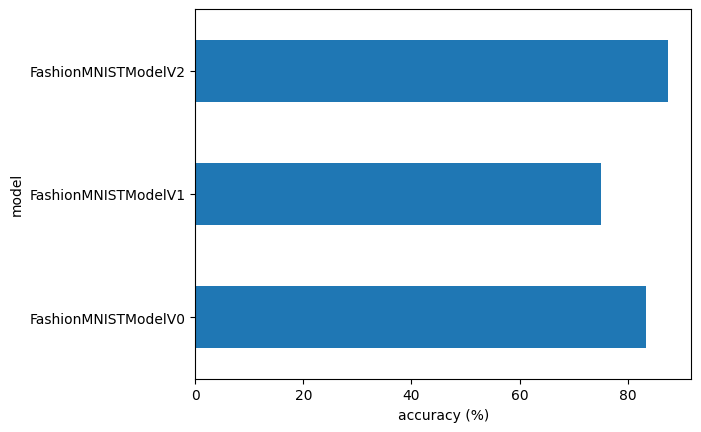

In [52]:
# Visulaize our model results
compare_results.set_index("model_name")["model_acc"].plot(kind = "barh")
plt.xlabel("accuracy (%)")
plt.ylabel("model")

## 9. Make and evaluate random predictions with best model

In [53]:
def make_predictions(model: torch.nn.Module,
                     data: list,
                     device: torch.device = device):
  pred_probs = []
  model.to(device)
  model.eval()
  with torch.inference_mode():
    for sample in data:
      # Prepare the sample
      sample = torch.unsqueeze(sample, dim = 0).to(device)

      # Forward pass (model outputs raw logits)
      pred_logits = model(sample)

      # Get the prediction probability (logit -> prediction probability)
      pred_prob = torch.softmax(pred_logits.squeeze(), dim = 0)

      # Get pred_prob off the GPU for further calculations
      pred_probs.append(pred_prob.cpu())

  # Stack the pred_probs to turn list into a tensor
  return torch.stack(pred_probs)

In [54]:
import random
random.seed(42)
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k = 9):
  test_samples.append(sample)
  test_labels.append(label)

# View the first sample shape
test_samples[0].shape

torch.Size([1, 28, 28])

Text(0.5, 1.0, 'Sandal')

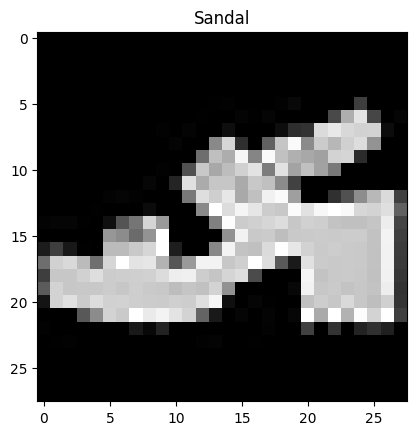

In [55]:
plt.imshow(test_samples[0].squeeze(), cmap = "gray")
plt.title(class_names[test_labels[0]])

In [56]:
# Make predictions
pred_probs = make_predictions(model = model_2,
                              data = test_samples)

# View first two prediction list
pred_probs[:2]

tensor([[8.9388e-08, 4.5712e-09, 3.5691e-08, 2.9502e-08, 7.2461e-09, 9.9984e-01,
         1.7525e-07, 7.7717e-06, 2.6169e-05, 1.2613e-04],
        [5.1709e-02, 7.2082e-01, 6.6542e-04, 7.1630e-02, 1.1103e-01, 2.5497e-05,
         4.3286e-02, 3.4781e-04, 4.1288e-04, 7.5562e-05]])

In [57]:
# Convert prediction probabilities to labels
pred_classes = pred_probs.argmax(dim = 1)
pred_classes

tensor([5, 1, 7, 4, 3, 0, 4, 7, 1])

In [58]:
test_labels

[5, 1, 7, 4, 3, 0, 4, 7, 1]

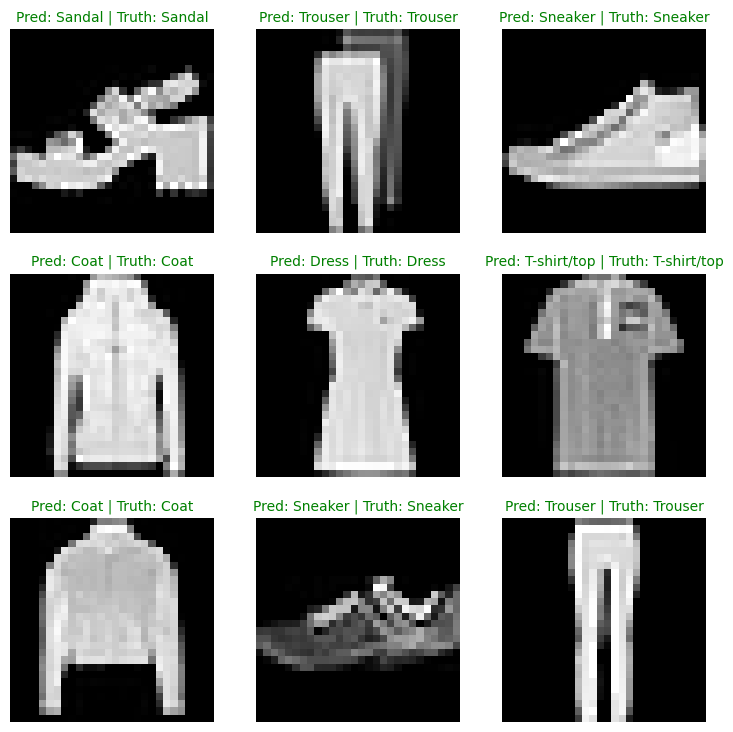

In [59]:
# Plot predictions
plt.figure(figsize = (9,9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
  # Create subplot
  plt.subplot(nrows, ncols, i + 1)

  # Plot the target image
  plt.imshow(sample.squeeze(), cmap = "gray")

  # Find the prediction (in text form, e.g "Sandal")
  pred_label = class_names[pred_classes[i]]

  # Get the truth label (in text form)
  truth_label = class_names[test_labels[i]]

  # Create a title for the ploy
  title_text = f"Pred: {pred_label} | Truth: {truth_label}"

  # Check for equality between pred and truth and change color of title text
  if pred_label == truth_label:
    plt.title(title_text, fontsize = 10, c = "g") # green text if prediction is same as truth
  else:
    plt.title(title_text, fontsize = 10, c = "r")

  plt.axis(False)

## 10. Making a confusion matrix for further prediction evaluation

1. Make predictions with our trained model on the test dataset.
2. Make a confusion matrix using `torchmetrics.ConfusionMatrix`.
3. Plot the confusion matrix using `mlxtend.plotting.plot_confusion_matrix`.

In [60]:
from tqdm.auto import tqdm

# 1. Make predictions with trained model
y_preds = []
model_2.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader, desc = "Making predictions..."):
    # Send the data and targets to target device
    X, y = X.to(device), y.to(device)
    # Do the forward pass
    y_logit = model_2(X)
    # Turn predictions from logits -> prediction probabilities -> prediction labels
    y_pred = torch.softmax(y_logit.squeeze(), dim = 0).argmax(dim = 1)
    # Put prediction on CPU for evaluation
    y_preds.append(y_pred.cpu())

# Concatenate list of predictions into a tensor
y_pred_tensor = torch.cat(y_preds)
y_pred_tensor


Making predictions...:   0%|          | 0/313 [00:00<?, ?it/s]

tensor([9, 2, 1,  ..., 8, 1, 8])

In [61]:
# See if required packages are installed and if not, install them...
try:
  import torchmetrics, mlxtend
  print(f"mlxtend version: {mlxtend.__version__}")
  assert int(mlxtend.__version__.split(".")[1] >= 19, "mlxtend version should be 0.19.0 or higher")
except:
  !pip install -q torchmetrics -U mlxtend
  import torchmetrics, mlxtend
  print(f"mlxtend version: {mlxtend.__version__}")

mlxtend version: 0.23.0
mlxtend version: 0.23.0


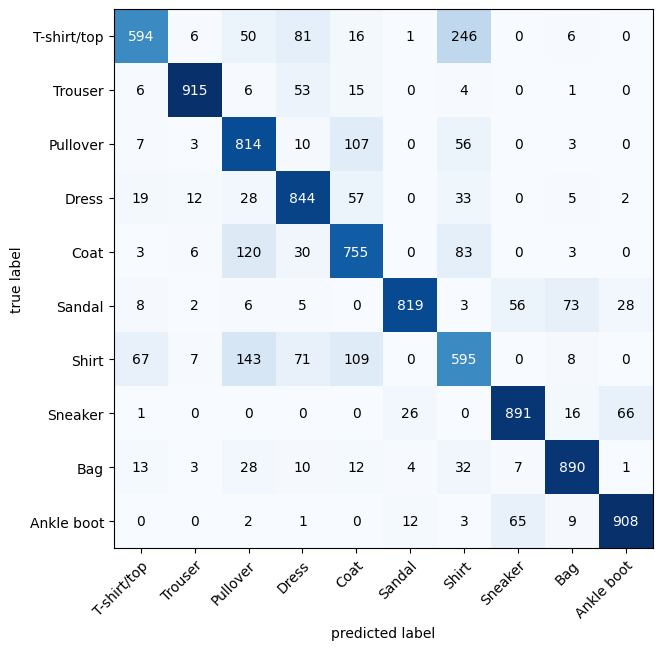

In [63]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# 2. Setup confusion instance and compare predictions to targets
confmat = ConfusionMatrix(num_classes = len(class_names), task='multiclass')
confmat_tensor = confmat(preds=y_pred_tensor,
                         target=test_data.targets)


# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat = confmat_tensor.numpy(), # matplot likes working with numpy
    class_names = class_names,
    figsize = (10,7)
)

## 11. Save and load best performing model

In [64]:
from pathlib import Path

# Create model directory path
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents = True,
                 exist_ok = True)

# Create a model save path
MODEL_NAME = "03_pytorch_computer_vision_model_2.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj = model_2.state_dict(),
           f = MODEL_SAVE_PATH)

Saving model to: models/03_pytorch_computer_vision_model_2.pth


In [66]:
# Create a new instance
torch.manual_seed(42)

loaded_model_2 = FashionMNISTModelV2(input_shape = 1,
                                hidden_units = 10,
                                     output_shape = len(class_names))

# Load in the saved state_dict()
loaded_model_2.load_state_dict(torch.load(f = MODEL_SAVE_PATH))

# Send the model to the target device
loaded_model_2.to(device)

FashionMNISTModelV2(
  (block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [67]:
model_2_results

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.33541926741600037,
 'model_acc': 87.45007987220447}

In [68]:
# Evaluate loaded model
torch.manual_seed(42)
loaded_model_2_results = eval_model(
    model = loaded_model_2,
    data_loader = test_dataloader,
    loss_fn = loss_fn,
    accuracy_fn = accuracy_fn
)

loaded_model_2_results

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.33541926741600037,
 'model_acc': 87.45007987220447}

In [70]:
# Check if model results are close to each other
torch.isclose(torch.tensor(model_2_results["model_loss"]),
              torch.tensor(loaded_model_2_results["model_loss"]))

tensor(True)